# Web Scraping Forms

In [1]:
import requests
from lxml import html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Examining Gas Prices:

Suppose I am interested in looking at weekly gas prices in California.  This data for 2019 appears on the web here:

https://ww2.energy.ca.gov/almanac/transportation_data/gasoline/margins/index_cms.php

### Load a Web Page with libxml

We follow the notebook for scraping data from Wikipedia and use HTTP to request the data.

In [2]:
url = "https://ww2.energy.ca.gov/almanac/transportation_data/gasoline/margins/index_cms.php"

In [3]:
resp = requests.get(url)

Let's check that the request was successful and examine some of the content.

In [4]:
resp.status_code

200

In [5]:
resp.content[:1000]

b'<!doctype html>\n<!--[if IE 9]>\n<html class="no-js ie9 oldie" lang="en"> <![endif]-->\n<!--[if (gt IE 9)]><!-->\n<html lang="en" class="full-width">\n<!--<![endif]-->\n<head>\n    <meta charset="utf-8">\n    <title>Estimated 2019 Gasoline Price Breakdown and Margins Details</title>\n    \n\n\n    <!-- Use highest compatibility mode -->\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0">\n\n    <!-- http://t.co/dKP3o1e -->\n    <meta name="HandheldFriendly" content="True">\n    <!-- for Blackberry, AvantGo -->\n    <meta name="MobileOptimized" content="320">\n\n    <!-- modernizr.com, feature detection -->\n    <script src="/assets/js/modernizr-custom.js" type="text/javascript"></script>\n\n    <!-- Helps prevent FOUC (Flash of Unstyled Content) on page load -->\n    <style>\n        html {\n            display: none;\n        }\n    </style>\n\n    <!-- Import Web Fonts Here (ex: Go

If we return to the website here: 

https://ww2.energy.ca.gov/almanac/transportation_data/gasoline/margins/index_cms.php

we see that this reflects the content on the website.

We parse the text content of the site into a tree (dom).

In [6]:
dom = html.document_fromstring(resp.content)

In [7]:
type(dom)

lxml.html.HtmlElement

When we search in the raw HTML for a date, we see that it is within an 'h2' tag in a 'caption' and it is not located in a table. This means that pandas html reading will not work.

In [8]:
weeks = dom.xpath('//table/caption/h2/text()')
weeks[:5]

['Oct 28', 'Oct 21', 'Oct 14', 'Oct 07', 'Sep 30']

We will tack on the year to the front of each string and then convert it to a datetime format for plotting.

In [9]:
weeks = pd.Series(weeks)
weeks = '2019-' + weeks
weeks[:5]

0    2019-Oct 28
1    2019-Oct 21
2    2019-Oct 14
3    2019-Oct 07
4    2019-Sep 30
dtype: object

In [10]:
weeks = pd.to_datetime(weeks, infer_datetime_format =True)

We want only the weekly prices so rather than parse the entire table, we will simple extract the prices in the row that has a cell with content "Retail Prices".  We do this with the following xpath expression.

In [11]:
prices = dom.xpath('//table/tr[th/text() = "Retail Prices"]/td[1]/text()')

In [12]:
prices[:5]

['$3.950', '$4.030', '$4.090', '$4.090', '$3.950']

We clean prices too. We remove the $-sign and convert the value to numeric. 

In [13]:
prices = pd.Series(prices).str.replace("$", "").astype(float)
prices[:5]

0    3.95
1    4.03
2    4.09
3    4.09
4    3.95
dtype: float64

We can create a DataFrame of the weekly dates and prices.

In [14]:
prices2019 = pd.DataFrame({ 'date': weeks, 'price': prices })
prices2019.head(7)

,date,price
0,2019-10-28,3.95
1,2019-10-21,4.03
2,2019-10-14,4.09
3,2019-10-07,4.09
4,2019-09-30,3.95
5,2019-09-23,3.61
6,2019-09-16,3.50


/Users/nolan/anaconda3/envs/ds100v2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


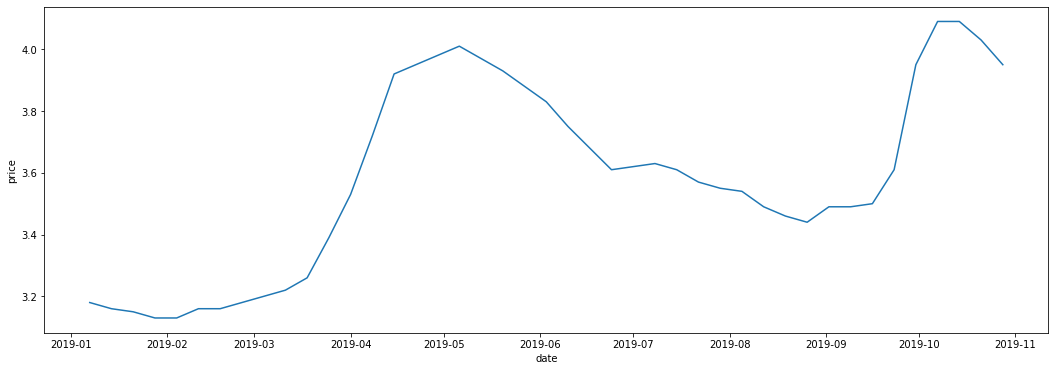

In [15]:
plt.figure(figsize=(18,6))
axs = sns.lineplot(y=prices2019['price'], x=prices2019['date'])

## Creating Generic Cleaning Functions

Because we plan to acquire more years and prepare them in the same way as we just did. We will create two simple functions that we can debug once and run on all 20+ web pages.

`extract_gas` will extract the weekly dates and prices from the ~50 tables in a page.

`clean_gas` will convert the date strings to datetimes and the price strings to float.

In [16]:
def extract_gas(dom):
    # Extract weeks
    weeks = dom.xpath('//table/caption/h2/text()')
    weeks2 = pd.Series(weeks)
    # Extract prices
    prices = dom.xpath('//table/tr[th/text() = "Retail Prices"]/td[1]/text()')
    return pd.DataFrame({ 'date': weeks2, 'price': prices })

In [17]:
def clean_gas(df, yr):
    # Add year and convert to date-time
    df["date"] = yr + '-' + df["date"]
    df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)
    # Remove $ and Change types
    df["price"] = df["price"].str.replace("$", "").astype(float)
    return df

We test these functions on our 2019 tree.

In [18]:
df = extract_gas(dom)
df.head()

,date,price
0,Oct 28,$3.950
1,Oct 21,$4.030
2,Oct 14,$4.090
3,Oct 07,$4.090
4,Sep 30,$3.950


In [19]:
df = clean_gas(df, "2019")
df.head()

,date,price
0,2019-10-28,3.95
1,2019-10-21,4.03
2,2019-10-14,4.09
3,2019-10-07,4.09
4,2019-09-30,3.95


## Submitting a Form

We see there is a form at the bottom of our original page.
Again, when we examine the raw HTML, we find that we can receive additional year's data by POSTing a request. 

We use the `requests` library to make the HTTP request for another year to test our code.

In [20]:
resp = requests.post(url, data = dict(year = "2012"))
resp.status_code

200

In [21]:
resp.request.method

'POST'

In [22]:
resp.request.body

'year=2012'

In [23]:
resp.request.path_url

'/almanac/transportation_data/gasoline/margins/index_cms.php'

In [24]:
for k in resp.request.headers:
    print(k, ":", resp.request.headers[k])

User-Agent : python-requests/2.22.0
Accept-Encoding : gzip, deflate
Accept : */*
Connection : keep-alive
Content-Length : 9
Content-Type : application/x-www-form-urlencoded


The request seems to have been successful.
We apply our extraction and cleaning functions to the 2012 data.

In [25]:
dom = html.document_fromstring(resp.content)
new_yr = clean_gas(extract_gas(dom), "2012")

new_yr.head(10)                  

,date,price
0,2012-12-31,3.55
1,2012-12-24,3.51
2,2012-12-17,3.53
3,2012-12-10,3.62
4,2012-12-03,3.70
5,2012-11-26,3.75
6,2012-11-19,3.78
7,2012-11-12,3.86
8,2012-11-05,4.00
9,2012-10-29,4.17


## Submitting Mulitple Forms

We will now programmatically request the data for all available years.

We begin by finding the select taqg with the id attribute 'year' and access all of the value attributes in the option children.

In [26]:
years = dom.xpath('//select[@id="year"]/option/@value')

In [27]:
years[:5]

['2019', '2019', '2018', '2017', '2016']

In [28]:
dfs = []

for y in years[1:]:
    print("Downloading Year:", y)

    # Get the data
    r = requests.post(url, data = {'year': y})
    
    # Get the html content
    dom = html.document_fromstring(r.content)

    # Extract and clean the date and price
    df = clean_gas(extract_gas(dom), y)

    # Save the dataframe
    dfs.append(df)

In [29]:
df_all_yr = pd.concat(dfs).reset_index(drop=True)

In [30]:
df_all_yr.tail()

,date,price
1029,1999-02-01,1.11
1030,1999-01-25,1.12
1031,1999-01-18,1.12
1032,1999-01-11,1.13
1033,1999-01-04,1.13


### Plotting the Prices over Time



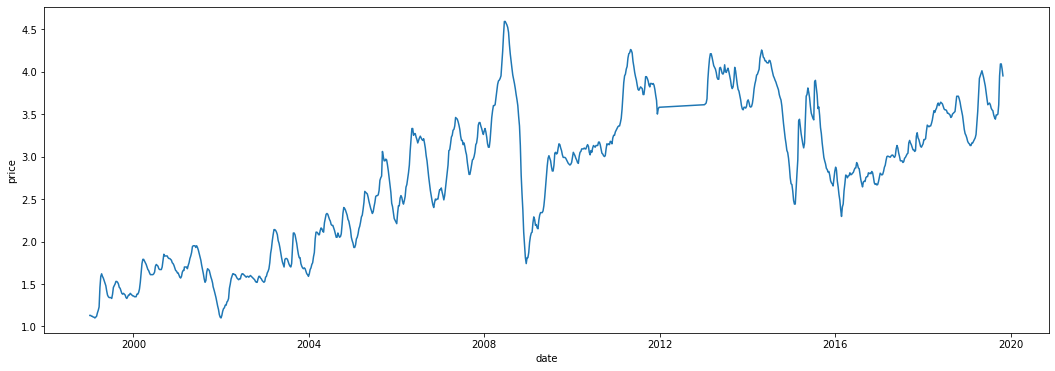

In [31]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(18,6))
axs = sns.lineplot(y="price", x="date", data = df_all_yr)

### Saving a backup
Let's save the data at this point in case we need to recover it later.

In [32]:
df_all_yr.to_csv("combined_gas_prices.csv")

### Beautiful Soup 

Here's how we would access the dates and prices from a page using Beautiful Soup.

In [33]:
from bs4 import BeautifulSoup

In [34]:
soup = BeautifulSoup(resp.content, 'lxml')

In [35]:
capSoup = soup.find_all('caption')

In [36]:
datesSoup = []
for c in capSoup:
    datesSoup.append(c.find('h2').text)

In [37]:
datesSoup[:5]

['Dec 31', 'Dec 24', 'Dec 17', 'Dec 10', 'Dec 03']

In [38]:
tabsSoup = soup.find_all('table')

In [39]:
pricesSoup = []
for t in tabsSoup:
    pricesSoup.append(t.find(string="Retail Prices").parent.next_sibling.text)

In [40]:
pricesSoup[:5]

['$3.55', '$3.51', '$3.53', '$3.62', '$3.70']

Here's how we would use Beautiful Soup to access the years in the form.

In [41]:
formSoup = soup.find_all(id="year")[0]

In [42]:
opt_tags = formSoup.find_all("option")

In [43]:
years = set([o.attrs["value"] for o in opt_tags]) 

In [44]:
years

{'1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019'}